# Train a CNN on gait cycles (TEMPLATE NOTEBOOK)

In [1]:
# Imports
import os
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(42)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.utils import class_weight

Using TensorFlow backend.
/home/groups/euan/users/danjwu/miniconda3/envs/MHC/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/groups/euan/users/danjwu/miniconda3/envs/MHC/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/groups/euan/users/danjwu/miniconda3/envs/MHC/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [2]:
# =============================================================================
# PARAMETERS
# =============================================================================

#File locations
output_dir = "/scratch/PI/euan/projects/mhc/code/daniel_code/results"
model_metrics = ['accuracy'] #,tpr,tnr,fpr,fnr,precision,f1]

#Training parameters
batch_size = 512

In [3]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0], batch_size = batch_size))).round()
        val_targ = self.validation_data[1]
        
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f' — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall {_val_recall}')
        return
 
metrix = Metrics()

# Training

In [6]:
#Load 15 axis data
print('Beginning loading')
#X_train = np.load('processed_datasets/gender_X_15.npy')
#y_train = np.load('processed_datasets/gender_y_15.npy')
#ids_train = np.load('processed_datasets/gender_ids_15.npy')

X_train = np.load('processed_datasets/Sex_X_15_aligned.npy')
y_train = np.load('processed_datasets/Sex_y_15_aligned.npy')
ids_train = np.load('processed_datasets/Sex_ids_15_aligned.npy')

print('Finished loading, beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

print('Beginning y_train encoding')

#Convert string to binary labels
y_train = y_train == 'Male'

#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(X_train, y_train, ids_train, train_size = 0.8)

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Beginning data splitting')

#Swap axes
X_train = X_train.swapaxes(-1, -2)

split_num = int(0.8*X_train.shape[0])
X_val = X_train[split_num:]
y_val = y_train[split_num:]
ids_val = ids_train[split_num:]

X_train = X_train[:split_num]
y_train = y_train[:split_num]
ids_train = ids_train[:split_num]

X_train.shape, X_val.shape, y_train.shape, y_val.shape, ids_train.shape, ids_val.shape

Beginning loading
Finished loading, beginning X_train axis adjustment
Beginning y_train encoding
Data is NOT randomized.
Beginning data splitting


((433563, 1, 100, 15),
 (108391, 1, 100, 15),
 (433563,),
 (108391,),
 (433563,),
 (108391,))

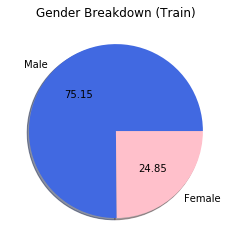

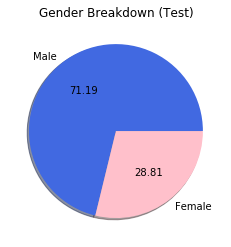

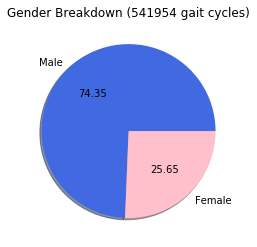

In [5]:
#Profile the dataset
num_male = np.sum(y_train == 1)
num_female = np.sum(y_train == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title("Gender Breakdown (Train)")
plt.show()

#Profile the dataset
num_male = np.sum(y_val == 1)
num_female = np.sum(y_val == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title("Gender Breakdown (Test)")
plt.show()

#Profile the dataset
num_male = np.sum(np.concatenate((y_train, y_val)) == 1)
num_female = np.sum(np.concatenate((y_train, y_val)) == 0)
plt.figure()
plt.pie([num_male, num_female], 
        labels = ['Male', 'Female'], 
        colors=['royalblue', 'pink'], 
        autopct = '%.2f', 
        shadow = True)
plt.title(f"Gender Breakdown ({num_male + num_female} gait cycles)")
plt.show()

In [11]:
# Build a resnet for kicks
from keras import backend
from keras import layers
from keras import models
from keras import utils as keras_utils



def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True,
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (1, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((1, 3), strides=(1, 2))(x)

    x = conv_block(x, (1, 3), [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, (1, 3), [64, 64, 256], stage=2, block='b')
    x = identity_block(x, (1, 3), [64, 64, 256], stage=2, block='c')

    x = conv_block(x, (1, 3), [128, 128, 512], stage=3, block='a')
    x = identity_block(x, (1, 3), [128, 128, 512], stage=3, block='b')
    x = identity_block(x, (1, 3), [128, 128, 512], stage=3, block='c')
    x = identity_block(x, (1, 3), [128, 128, 512], stage=3, block='d')

    x = conv_block(x, (1, 3), [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, (1, 3), [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, (1, 3), [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, (1, 3), [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, (1, 3), [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, (1, 3), [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, (1, 3), [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, (1, 3), [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, (1, 3), [512, 512, 2048], stage=5, block='c')

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='sigmoid' if classes == 1 else 'softmax', name='prediction')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Create model.
    model = models.Model(img_input, x, name='resnet50')
            
    return model

In [24]:
#Set the model up
#model = get_mod_model()
#model = get_model()
model = ResNet50(include_top=True,
             input_tensor=None,
             input_shape=(1, 100, 15),
             pooling=None,
             classes=1)

model.summary()

print(model.summary())

#Define optimizer
adam = keras.optimizers.Adam() #Default lr is 0.001

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=model_metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1, 100, 15)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 7, 106, 15)   0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 4, 50, 64)    6784        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 4, 50, 64)    256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [25]:
#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-7, verbose=1)

early_stop = EarlyStopping(patience=4, verbose=1, restore_best_weights=True)

#tb = TensorBoard(log_dir=os.path.join(output_dir, 'logs'), 
#                 write_graph=False,) 
                 #histogram_freq=5, 
                 #embeddings_freq=5, 
                 #embeddings_layer_names=['fc1'],
                 #mbeddings_data = X_val)

cb_list = [reduce_lr, early_stop, metrix]

In [18]:
history = model.fit(x = X_train,#.squeeze().swapaxes(-1, -2),
                    y = y_train,
                    epochs=20,
                    validation_data = (X_val, y_val),#.squeeze().swapaxes(-1, -2), y_val),
                    callbacks = cb_list,
                    class_weight={0: 1.6218955904713634, 1: 0.7228371357578496}, #class_weights,
                    shuffle=True, 
                    batch_size = batch_size)

Train on 433563 samples, validate on 108391 samples
Epoch 1/20
433563/433563 [==============================] - 210s 483us/step - loss: 0.6471 - acc: 0.7508 - val_loss: 0.6410 - val_acc: 0.7119
 — val_f1: 0.8316976820638846 — val_precision: 0.7118856731647462 — val_recall 1.0
Epoch 2/20
433563/433563 [==============================] - 184s 424us/step - loss: 0.6455 - acc: 0.7515 - val_loss: 0.6411 - val_acc: 0.7119
 — val_f1: 0.8316976820638846 — val_precision: 0.7118856731647462 — val_recall 1.0
Epoch 3/20
433563/433563 [==============================] - 184s 425us/step - loss: 0.6455 - acc: 0.7515 - val_loss: 0.6410 - val_acc: 0.7119

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
 — val_f1: 0.8316976820638846 — val_precision: 0.7118856731647462 — val_recall 1.0
Epoch 4/20
433563/433563 [==============================] - 184s 426us/step - loss: 0.6455 - acc: 0.7515 - val_loss: 0.6413 - val_acc: 0.7119
 — val_f1: 0.8316976820638846 — val_precision: 0.

In [26]:
#Try a generator for fun
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=512, shuffle=True):
        self.batch_size = batch_size
        self.y = y
        self.X = X
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate the batch
        X = self.X[idxs]
        y = self.y[idxs]
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
train_gen = DataGenerator(X_train, y_train)
val_gen = DataGenerator(X_val, y_val)

In [27]:
history = model.fit_generator(train_gen,
                    steps_per_epoch = 200,
                    epochs = 200,
                    validation_data = (X_val, y_val),#.squeeze().swapaxes(-1, -2), y_val),
                    callbacks = cb_list,
                    class_weight={0: 1.5, 1: 0.5}, #class_weights,
                    shuffle=True)

Epoch 1/200
200/200 [==============================] - 69s 346ms/step - loss: 0.5193 - acc: 0.5853 - val_loss: 0.6918 - val_acc: 0.7119
 — val_f1: 0.8316976820638846 — val_precision: 0.7118856731647462 — val_recall 1.0
Epoch 2/200
200/200 [==============================] - 55s 276ms/step - loss: 0.5181 - acc: 0.7525 - val_loss: 0.6913 - val_acc: 0.7119
 — val_f1: 0.8316976820638846 — val_precision: 0.7118856731647462 — val_recall 1.0
Epoch 3/200
200/200 [==============================] - 55s 277ms/step - loss: 0.5192 - acc: 0.7509 - val_loss: 0.6925 - val_acc: 0.7119
 — val_f1: 0.8316976820638846 — val_precision: 0.7118856731647462 — val_recall 1.0
Epoch 4/200
200/200 [==============================] - 55s 277ms/step - loss: 0.5191 - acc: 0.7511 - val_loss: 0.6916 - val_acc: 0.7119

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
 — val_f1: 0.8316976820638846 — val_precision: 0.7118856731647462 — val_recall 1.0
Epoch 5/200
200/200 [=====================

In [13]:
model.save('models/aligned_gender_model_15.h5')

# Visualize Results

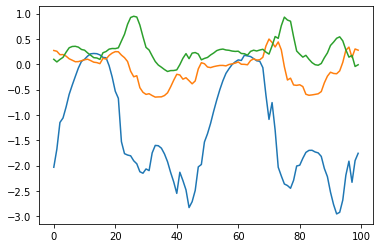

In [14]:
plt.plot(X_train.squeeze()[0, 0:3].T)

In [28]:
#Example predictions
pred = np.round(model.predict(X_val, batch_size = batch_size)).squeeze()#.squeeze().swapaxes(-1, -2))).squeeze()
print(f"{pred.sum()/len(pred)} of the predictions were 1 (Male)")

1.0 of the predictions were 1 (Male)


In [20]:
np.sum(pred == y_val), pred.shape

(77162, (108391,))

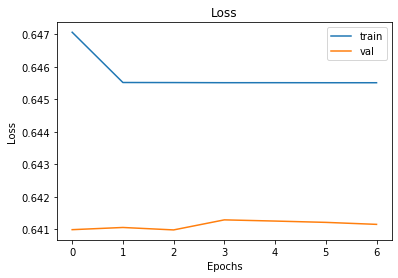

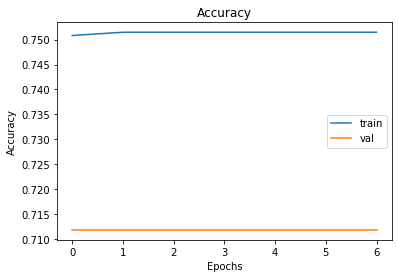

In [21]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [22]:
y_pred = model.predict(X_val, batch_size = batch_size)

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

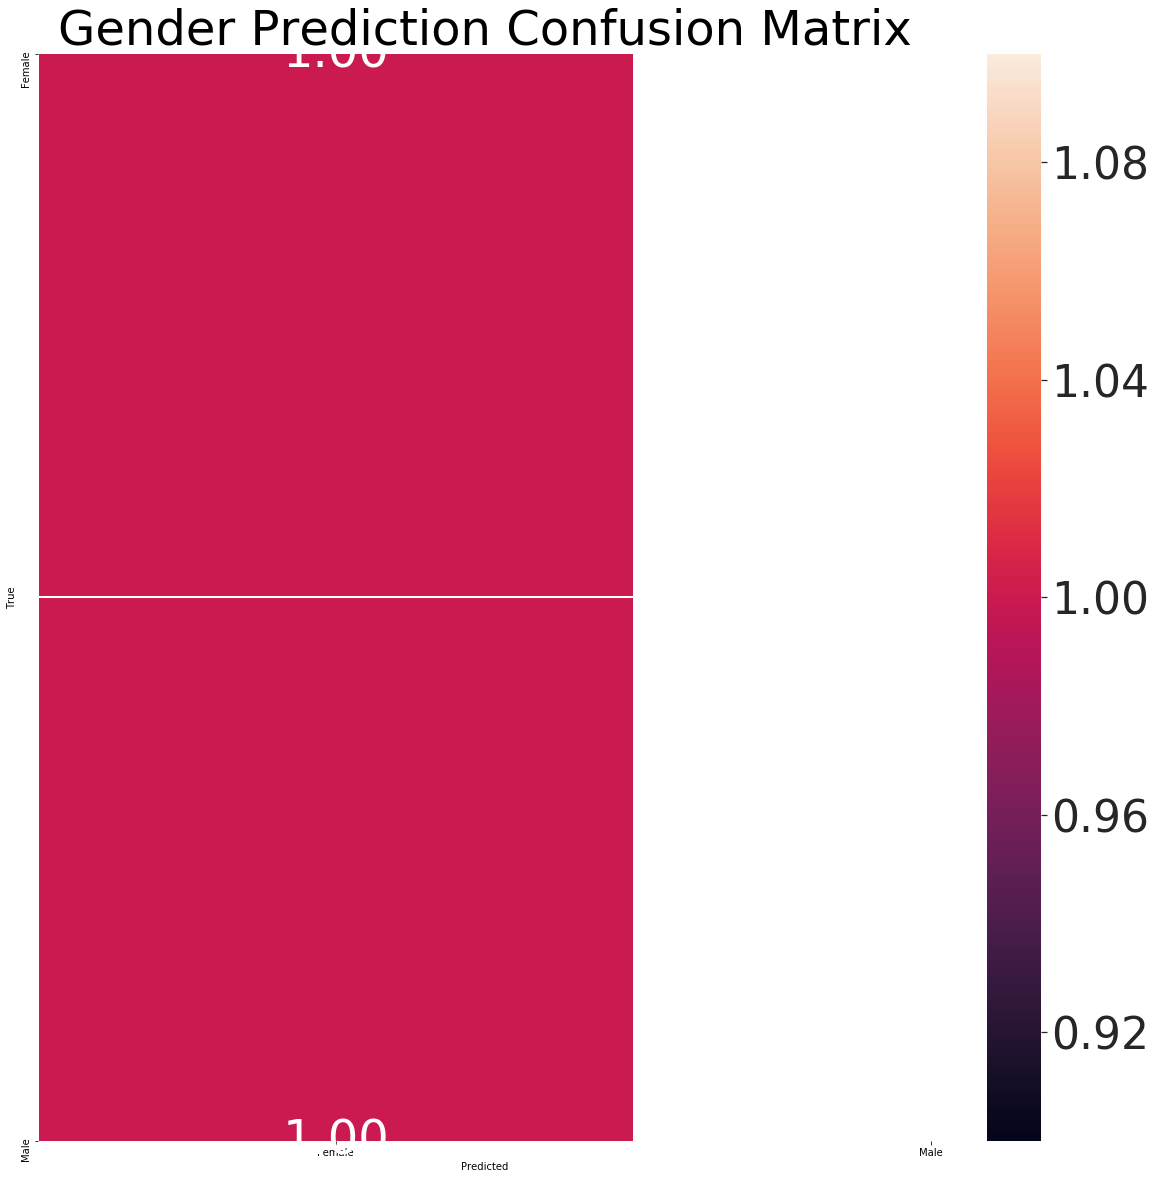

In [23]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_val,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

AUROC: 0.7925634551340094


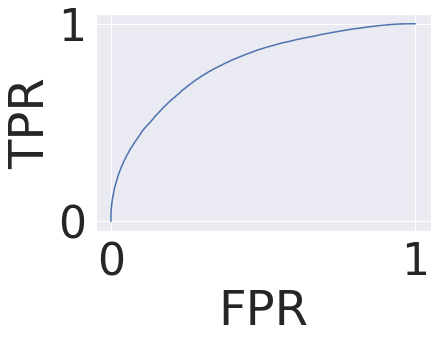

In [20]:
#ROC curve
from sklearn import metrics
y_score = model.predict(X_val, batch_size = batch_size)
fpr, tpr, threshs = metrics.roc_curve(y_val, y_score)

print("AUROC: {}".format(metrics.roc_auc_score(y_val, y_score)))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

AUROC: 0.8996827366814745


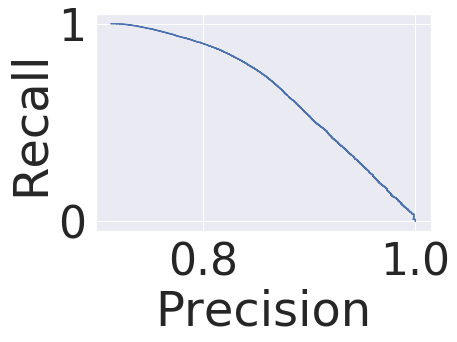

In [21]:
#PRC
p, r, threshs = metrics.precision_recall_curve(y_val, y_score)

print("AUROC: {}".format(metrics.average_precision_score(y_val, y_score)))

plt.figure()
plt.plot(p, r)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

# Get user-level predictions

In [22]:
y_round = y_pred.round()

unique_ids = np.unique(ids_val)
print(f'There are {len(unique_ids)} unique ids in our val set.')

user_preds = []
user_trues = []

overall_acc = []
male_acc = []
female_acc = []
for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(ids_val == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    temp = np.sum(y_round[usr_idxs])/len(usr_idxs)
    pred = temp > 0.5
    true = y_val[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')

    user_preds.append(pred)
    user_trues.append(true)
    
    overall_acc.append(true == pred)
    if true == 1:
        male_acc.append(true == pred)
    else:
        female_acc.append(true == pred)

There are 736 unique ids in our val set.


In [23]:
np.sum(overall_acc)/len(overall_acc)

0.8206521739130435

In [24]:
np.sum(female_acc)/len(female_acc)

0.6827956989247311

In [25]:
np.sum(male_acc)/len(male_acc)

0.8672727272727273

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

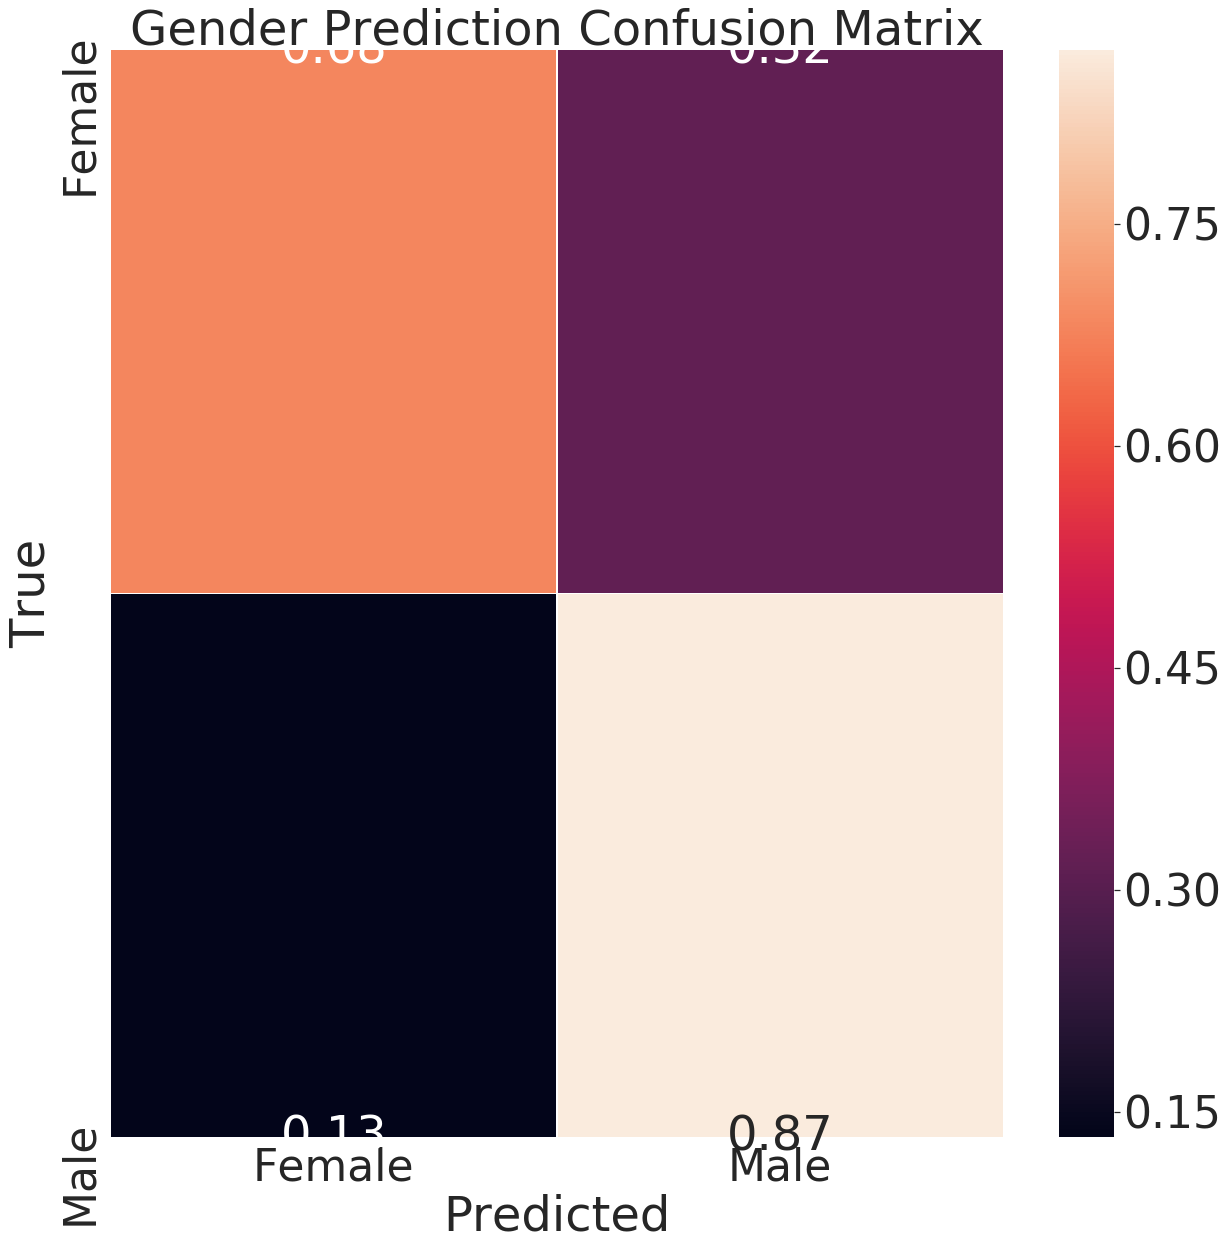

In [26]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((user_trues, user_preds)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

# SHAP it

In [26]:
import shap
shap.initjs()

In [27]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)

[101215 204480 123372  92284 185552]


<Figure size 1800x720 with 0 Axes>

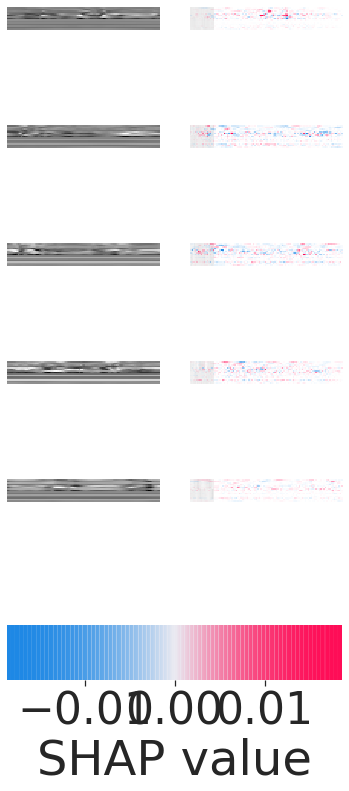

In [28]:
random_idxs = np.random.choice(np.arange(X_val.shape[0]), 5)
print(random_idxs)

shap_values = e.shap_values(X_val[random_idxs])

#Hack the dims a little
shap_values = [np.transpose(value, (0, 2, 3, 1)) for value in shap_values]
im_val = np.transpose(X_val, (0, 2, 3, 1))

# plot the feature attributions
plt.figure(figsize=(25, 10))
shap.image_plot(shap_values, -im_val[random_idxs], width = 100, aspect = 1)

Walk Cycle 0


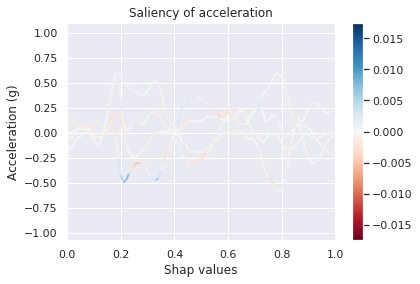

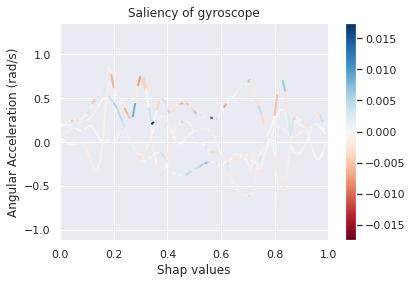

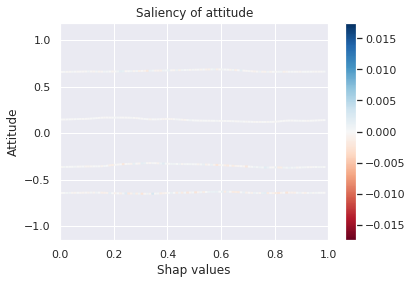

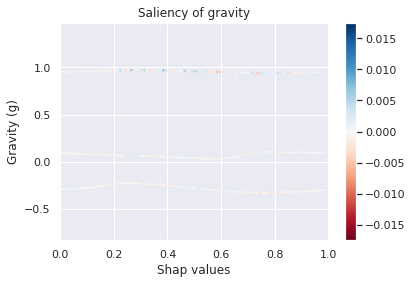

Walk Cycle 1


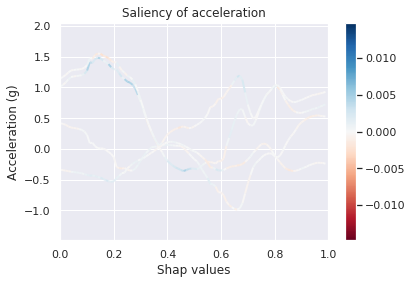

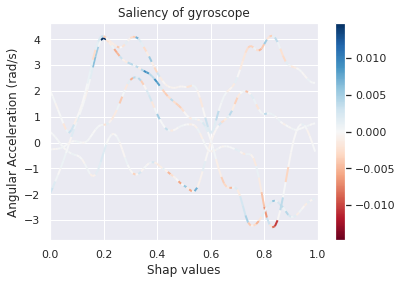

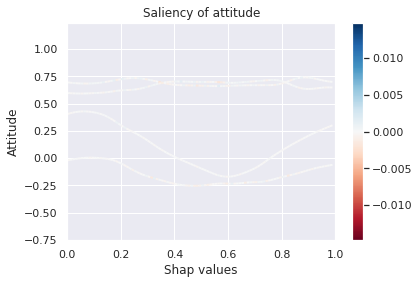

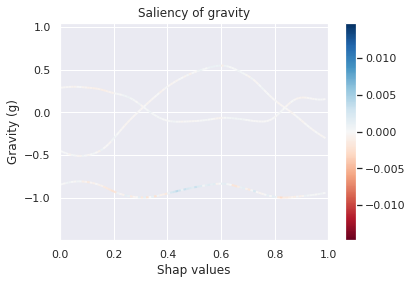

Walk Cycle 2


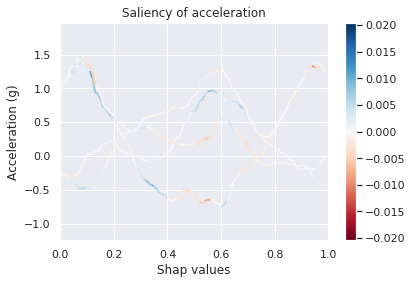

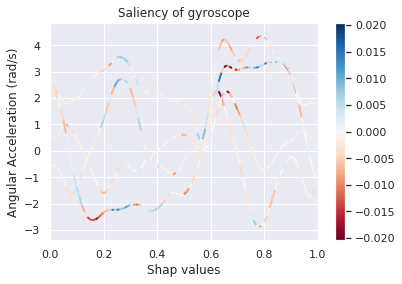

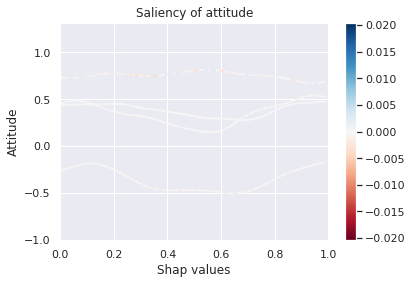

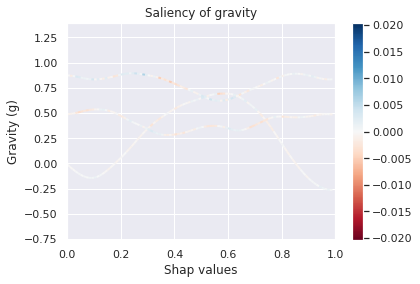

Walk Cycle 3


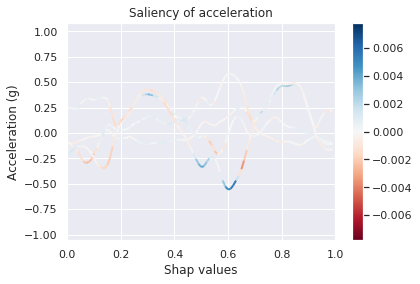

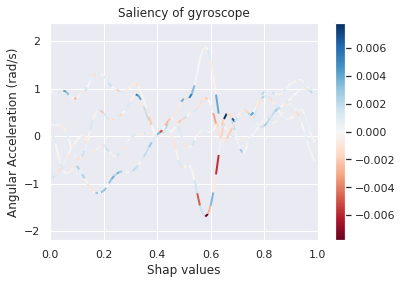

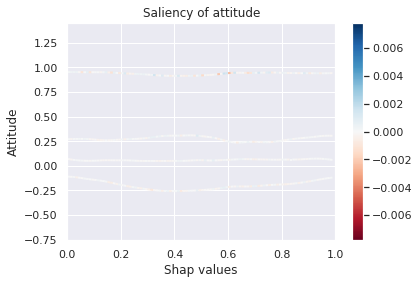

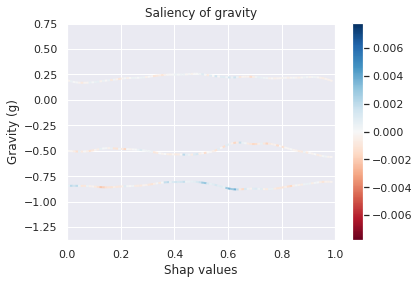

Walk Cycle 4


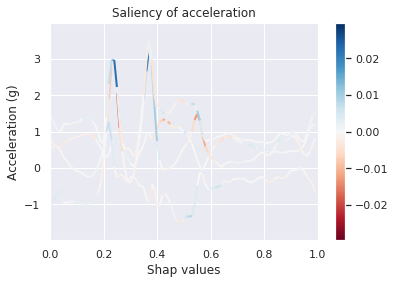

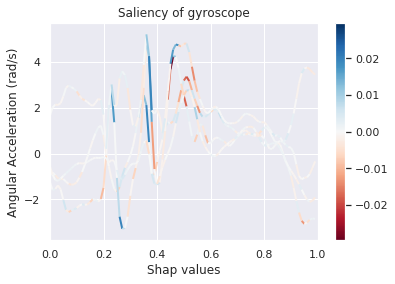

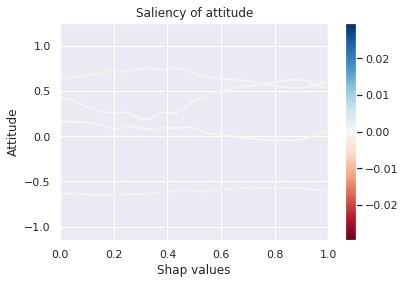

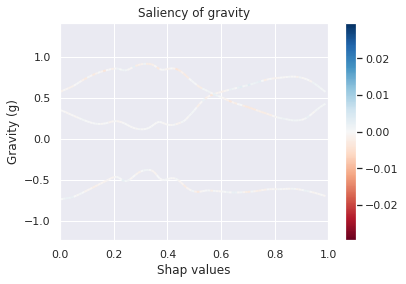

In [29]:
# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)

sns.set(font_scale = 1)

def plot_colored_data(data, color, shap_color_scale = None, fignum = 0, colorbar = False):
    from matplotlib.collections import LineCollection

    x = np.arange(0, len(data)) / 100
    points = np.array([x, data]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig = plt.figure(fignum)
    ax = plt.gca()

    # Create a continuous norm to map from data points to colors
    if shap_color_scale == None:
        norm = plt.Normalize(min(color), max(color))
    else:
        norm = plt.Normalize(-shap_color_scale, shap_color_scale)
    lc = LineCollection(segments, cmap='RdBu', norm=norm)

    # Set the values used for colormapping
    lc.set_array(color)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    if colorbar:
        fig.colorbar(line, ax = ax)

    
def plot_window_saliency(image, shap, base_fignum = 0):
    wc_data = image.squeeze()
    wc_saliency = shap.squeeze()
    largest_shap = np.max(np.abs(wc_saliency))

    #Plotting Accel
    plt.figure(base_fignum)
    for i in range(4):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum = base_fignum, colorbar = i == 3)
    
    plt.title('Saliency of acceleration')
    plt.ylabel('Acceleration (g)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[0:4]) - 0.5, np.max(wc_data[0:4]) + 0.5])
    
    #Plotting gyro
    plt.figure(base_fignum + 1)
    for i in range(4, 8):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  1, colorbar = i == 7)
    
    plt.title('Saliency of gyroscope')
    plt.ylabel('Angular Acceleration (rad/s)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[4:8]) - 0.5, np.max(wc_data[4:8]) + 0.5])
    
    plt.figure(base_fignum + 2)
    for i in range(8,12):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  2, colorbar = i == 11)
    
    plt.title('Saliency of attitude')
    plt.ylabel('Attitude')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[8:12]) - 0.5, np.max(wc_data[8:12]) + 0.5])
    
    plt.figure(base_fignum + 3)
    for i in range(12, 15):
    
        plot_colored_data(wc_data[i], wc_saliency[i], largest_shap, fignum =base_fignum +  3, colorbar = i == 14)
    
    plt.title('Saliency of gravity')
    plt.ylabel('Gravity (g)')
    plt.xlabel('Shap values')
    plt.xlim([0, 1])
    plt.ylim([np.min(wc_data[12:15]) - 0.5, np.max(wc_data[12:15]) + 0.5])
    
def plot_cycle_saliency(model, X_train, X_val):
    import shap
    shap.initjs()
    
    # select a set of background examples to take an expectation over
    background = X_train[np.random.choice(X_train.shape[0], 200, replace=False)]

    # explain predictions of the model on four images
    e = shap.DeepExplainer(model, background)
    
    #Choose some random cycles to plot
    random_idxs = np.random.choice(np.arange(X_val.shape[0]), 5)
    val_cycles = X_val[random_idxs]

    shap_values = e.shap_values(val_cycles)[0]
    
    for idx in range(len(random_idxs)):
        print(f"Walk Cycle {idx}")
        plot_window_saliency(val_cycles[idx], shap_values[idx], 4*idx)
        plt.show()
        
plot_cycle_saliency(model, X_train, X_val)

# That's it folks!

Text(0.5, 1, 'Gender Prediction Confusion Matrix')

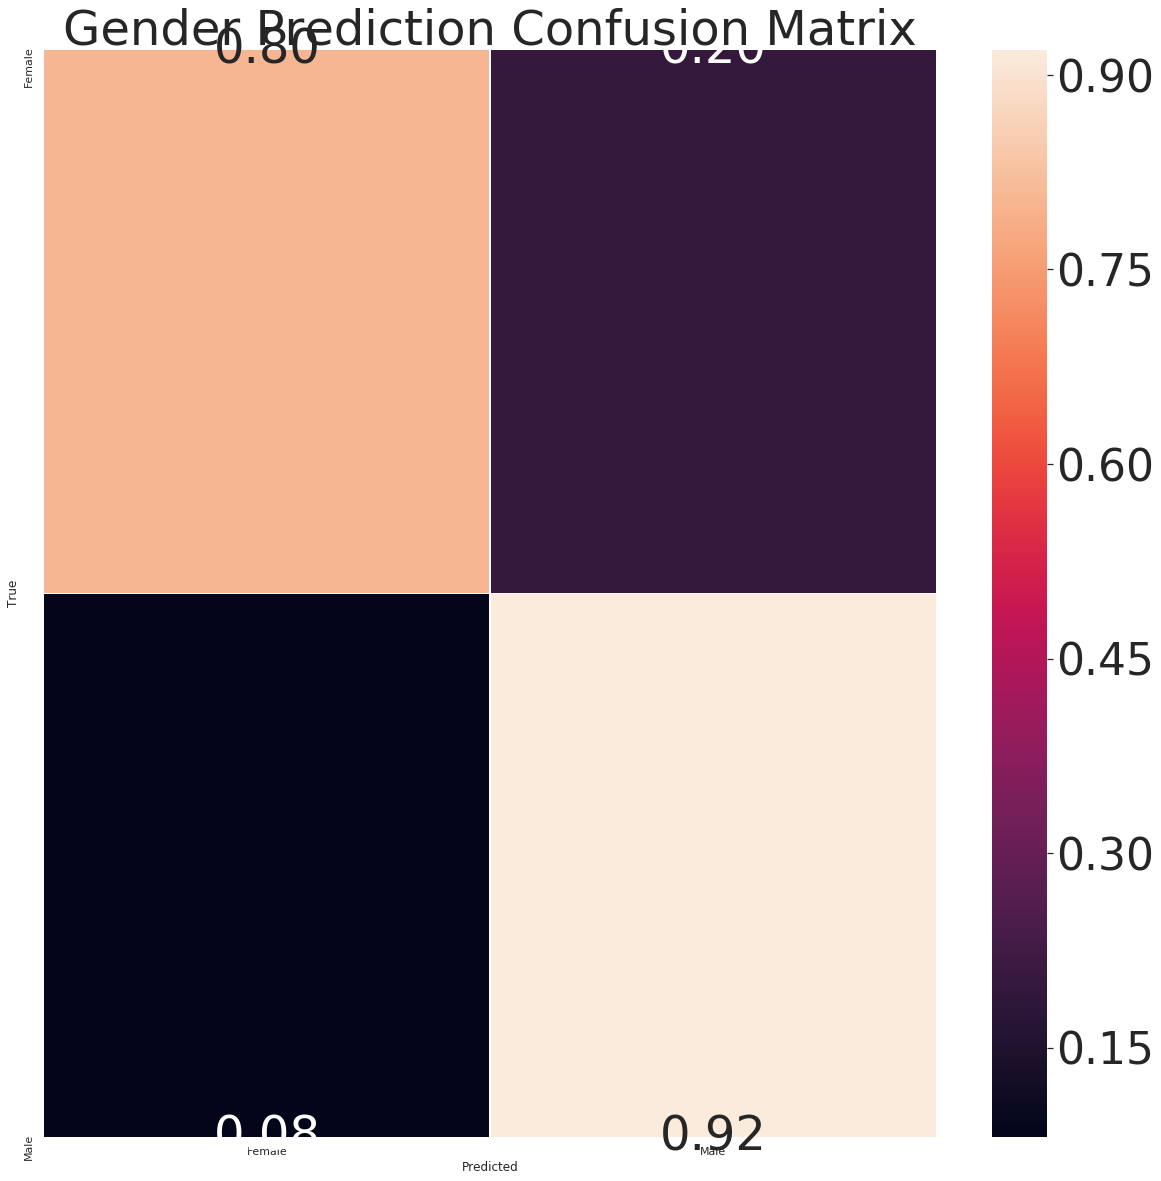

In [85]:
#Print confusion matrix
import seaborn as sns
y_pred = model.predict(X_val, batch_size = batch_size)
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_val,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')